In [ ]:
#!/usr/bin/env python

import torch
import various_data_functions
from torch import nn
from torch import optim
from torch import Tensor
from torch.nn import functional as F
import dlc_practical_prologue as prologue
import matplotlib.pyplot as plt
%matplotlib notebook

In [ ]:
#Data generation
N=10**3
#train_input,train_target,train_classes,test_input,test_target,test_classes=prologue.generate_pair_sets(N)
train_input,train_target,train_classes,test_input,test_target,test_classes=various_data_functions.data(N,True,False,nn.CrossEntropyLoss)
#train_target=train_target.long()#.float for MSELoss, .long for CrossEntropy
#train_input=train_input.float()
#train_classes=train_classes.long()

In [ ]:
#Base functions adapted from the practicals
def train_model(model, train_input, train_target,train_classes, mini_batch_size, crit=nn.MSELoss, eta = 1e-3, nb_epochs = 500,print_=False, store_loss = False):
    criterion = crit()
    optimizer = optim.SGD(model.parameters(), lr = eta)
    stored = []
    for e in range(nb_epochs):
        acc_loss = 0
        acc_loss1 = 0
        acc_loss2 = 0
        acc_loss3 = 0

        for b in range(0, train_input.size(0), mini_batch_size):
            output,aux_output = model(train_input.narrow(0, b, mini_batch_size))
            if crit==nn.MSELoss:
                loss1 = criterion(output[:,1], train_target.narrow(0, b, mini_batch_size))
                #print(torch.argmax(aux_output[:,0:9],dim=1))
                #print(train_classes[:,0].narrow(0, b, mini_batch_size))
                loss2 = criterion(torch.argmax(aux_output[:,0:9],dim=1), train_classes[:,0].narrow(0, b, mini_batch_size))
                loss3 = criterion(torch.argmax(aux_output[:,10:19],dim=1), train_classes[:,1].narrow(0, b, mini_batch_size))
                loss = loss1 + loss2 + loss3
                print('|| loss1 req grad =', loss1.requires_grad, '|| loss2 req grad =',loss2.requires_grad,'|| loss3 req grad =', loss3.requires_grad)
            elif crit==nn.CrossEntropyLoss:
                loss1 = criterion(output, train_target.narrow(0, b, mini_batch_size))
                #print(torch.argmax(aux_output[:,0:9],dim=1))
                #print(train_classes[:,0].narrow(0, b, mini_batch_size))
                loss2 = criterion(aux_output[:,:10], train_classes[:,0].narrow(0, b, mini_batch_size))
                loss3 = criterion(aux_output[:,10:], train_classes[:,1].narrow(0, b, mini_batch_size))
                loss = loss1 + 0.1*(loss2 + loss3)
                #print(loss1, loss2.requires_grad, loss3.requires_grad)
            else:
                print("Loss not implemented")
            acc_loss = acc_loss + loss.item()
            acc_loss1 = acc_loss1 + loss1.item()
            acc_loss2 = acc_loss2 + loss2.item()
            acc_loss3 = acc_loss3 + loss3.item()
                
            model.zero_grad()
            loss.backward()
            optimizer.step()
            if False:
                with torch.no_grad():
                    for p in model.parameters():
                        p -= eta * p.grad
        if store_loss:
                stored += [[acc_loss1], [acc_loss2], [acc_loss3]]
        if print_:
            print(e, 'tot loss', acc_loss, 'loss1', acc_loss1, 'loss2', acc_loss2, 'loss3', acc_loss3)
        
            
    return torch.tensor(stored)
    
def compute_nb_errors(model, input, target, mini_batch_size=100):
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output , aux_output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.max(1)
        for k in range(mini_batch_size):
            if target[b + k]!=predicted_classes[k]:
                nb_errors = nb_errors + 1

    return nb_errors

def run_many_times(model,crit=nn.MSELoss,mini_batch_size=100,n=10,print_=False,eta=1e-3,nb_epochs=500):
    average_error=0
    for i in range(n):
        m=model()
        train_model(m, train_input, train_target,train_classes,mini_batch_size,crit=crit,eta=eta,nb_epochs=nb_epochs)
        nb_test_errors = compute_nb_errors(m, test_input, test_target, mini_batch_size)
        print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                      nb_test_errors, test_input.size(0)))
        average_error+=(100 * nb_test_errors) / test_input.size(0)
    print("Average error: "+str(average_error/n))

In [ ]:
#Is it better to use groups or not?
#Takes about 2 hours to run
#about 22.5% error average without groups if we exclude outliers that get stuck and don't move
#about 21.5% error average with groups if we exclude outliers that get stuck and don't move
class NetGroups3200Aux20(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 200, kernel_size=3,groups=2)
        #self.conv2 = nn.Conv2d(32, 64, kernel_size=2)
        self.fc1 = nn.Linear(3200, 20)
        self.fc2 = nn.Linear(20, 2)
        self.aux_linear = nn.Linear(20, 20)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        #x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        aux_output = F.softmax(self.fc1(x.view(-1, 3200)), dim=1)
        x = F.relu(self.fc1(x.view(-1, 3200)))
        output = F.softmax(self.fc2(x), dim=1)
        aux_output = F.softmax(x, dim=1)
        return output, aux_output
    
class NetGroups3200Aux20_20(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 200, kernel_size=3,groups=2)
        #self.conv2 = nn.Conv2d(32, 64, kernel_size=2)
        self.fc1 = nn.Linear(3200, 20)
        self.fc2 = nn.Linear(20, 2)
        self.aux_linear = nn.Linear(20, 20)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        #x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        aux_output = F.softmax(self.fc1(x.view(-1, 3200)), dim=1)
        x = F.relu(self.fc1(x.view(-1, 3200)))
        output = F.softmax(self.fc2(x), dim=1)
        aux_output = F.softmax(self.aux_linear(x), dim=1)
        return output, aux_output

class NetGroups1600_400Aux20(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 100, kernel_size=3,groups=2)
        #self.conv2 = nn.Conv2d(32, 64, kernel_size=2)
        self.fc1 = nn.Linear(1600, 400)
        self.fc2 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 2)
        self.aux_linear = nn.Linear(20, 20)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        #x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 1600)))
        x = F.relu(self.fc2(x))
        aux_output = F.softmax(x, dim=1)
        output = F.softmax(self.fc3(x),dim=1)
        return output, aux_output

class NetGroups320_160_80_40Aux20(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 20, kernel_size=3,groups=2)
        #self.conv2 = nn.Conv2d(32, 64, kernel_size=2)
        self.fc1 = nn.Linear(320, 160)
        self.fc2 = nn.Linear(160, 80)
        self.fc3 = nn.Linear(80,40)
        self.fc4 = nn.Linear(40,20)
        self.fc5 = nn.Linear(20, 2)
        self.aux_linear = nn.Linear(20, 20)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        #x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 320)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        aux_output = F.softmax(x, dim=1)
        output = F.softmax(self.fc5(x),dim=1)
        return output, aux_output
    
class NetGroupsDoubleConvAux20(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3,groups=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,groups=2)
        self.fc1 = nn.Linear(256, 20)
        self.fc2 = nn.Linear(20, 2)
        self.aux_linear = nn.Linear(20, 20)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        aux_output = F.softmax(self.fc1(x.view(-1, 256)), dim=1)
        x = F.relu(self.fc1(x.view(-1, 256)))
        output = F.softmax(self.fc2(x), dim=1)
        aux_output = F.softmax(x, dim=1)
        return output, aux_output
    
class NetGroups320_80DoubleConvAux20(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 80, kernel_size=3,groups=2)
        self.conv2 = nn.Conv2d(80, 320, kernel_size=3,groups=2)
        self.fc1 = nn.Linear(1280, 320)
        self.fc2 = nn.Linear(320, 80)
        self.fc3 = nn.Linear(80, 20)
        self.aux_linear = nn.Linear(20, 20)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        aux_output = F.softmax(self.fc1(x.view(-1, 1280)), dim=1)
        x = F.relu(self.fc1(x.view(-1, 1280)))
        x = F.relu(self.fc2(x))
        output = F.softmax(self.fc3(x), dim=1)
        aux_output = F.softmax(x, dim=1)
        return output, aux_output

In [ ]:
run_many_times(NetGroups3200Aux20,crit=nn.CrossEntropyLoss)

test error Net 47.70% 477/1000
test error Net 47.60% 476/1000
test error Net 47.40% 474/1000
test error Net 47.20% 472/1000
test error Net 45.60% 456/1000
test error Net 47.30% 473/1000
test error Net 46.60% 466/1000
test error Net 46.80% 468/1000
test error Net 44.90% 449/1000
test error Net 49.40% 494/1000
Average error: 47.05


In [ ]:
mini_batch_size=100
n=10
eta=1e-3
nb_epochs=100
crit=nn.CrossEntropyLoss
model = NetGroups3200Aux20()
losses = train_model(model, train_input, train_target,train_classes, mini_batch_size, crit, eta, nb_epochs,print_=False, store_loss = True)

tensor([[ 6.9886],
        [23.0235],
        [23.0323],
        [ 6.9097],
        [23.0243],
        [23.0308],
        [ 6.8631],
        [23.0248],
        [23.0295],
        [ 6.8331],
        [23.0251],
        [23.0284],
        [ 6.8106],
        [23.0253],
        [23.0272],
        [ 6.7913],
        [23.0255],
        [23.0260],
        [ 6.7735],
        [23.0257],
        [23.0249],
        [ 6.7562],
        [23.0260],
        [23.0239],
        [ 6.7388],
        [23.0264],
        [23.0231],
        [ 6.7217],
        [23.0270],
        [23.0223],
        [ 6.7044],
        [23.0278],
        [23.0215],
        [ 6.6882],
        [23.0284],
        [23.0208],
        [ 6.6727],
        [23.0287],
        [23.0201],
        [ 6.6579],
        [23.0287],
        [23.0193],
        [ 6.6431],
        [23.0287],
        [23.0185],
        [ 6.6289],
        [23.0286],
        [23.0178],
        [ 6.6150],
        [23.0285],
        [23.0170],
        [ 6.6017],
        [23.

<IPython.core.display.Javascript object>


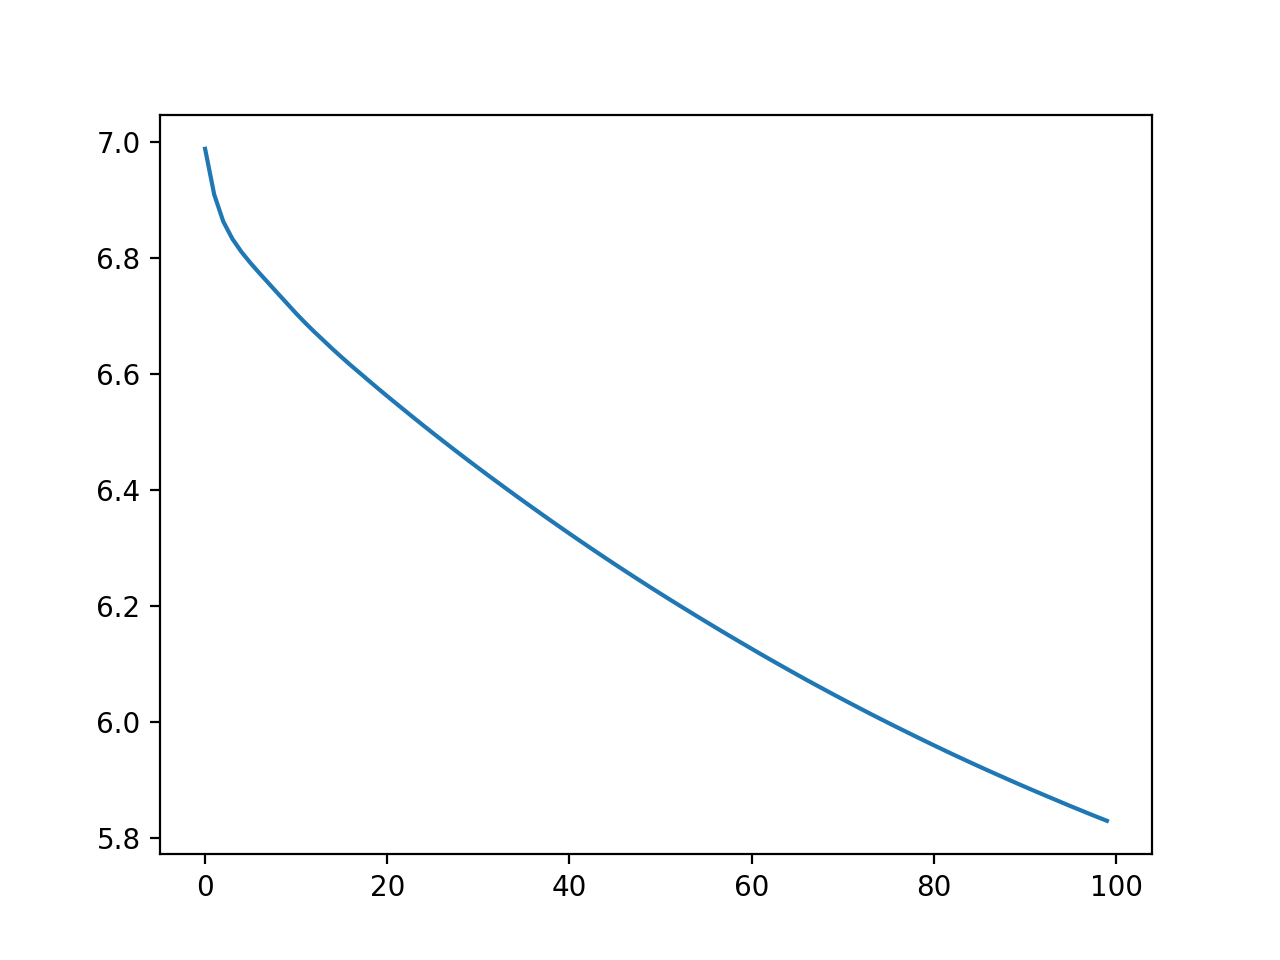

<IPython.core.display.Javascript object>


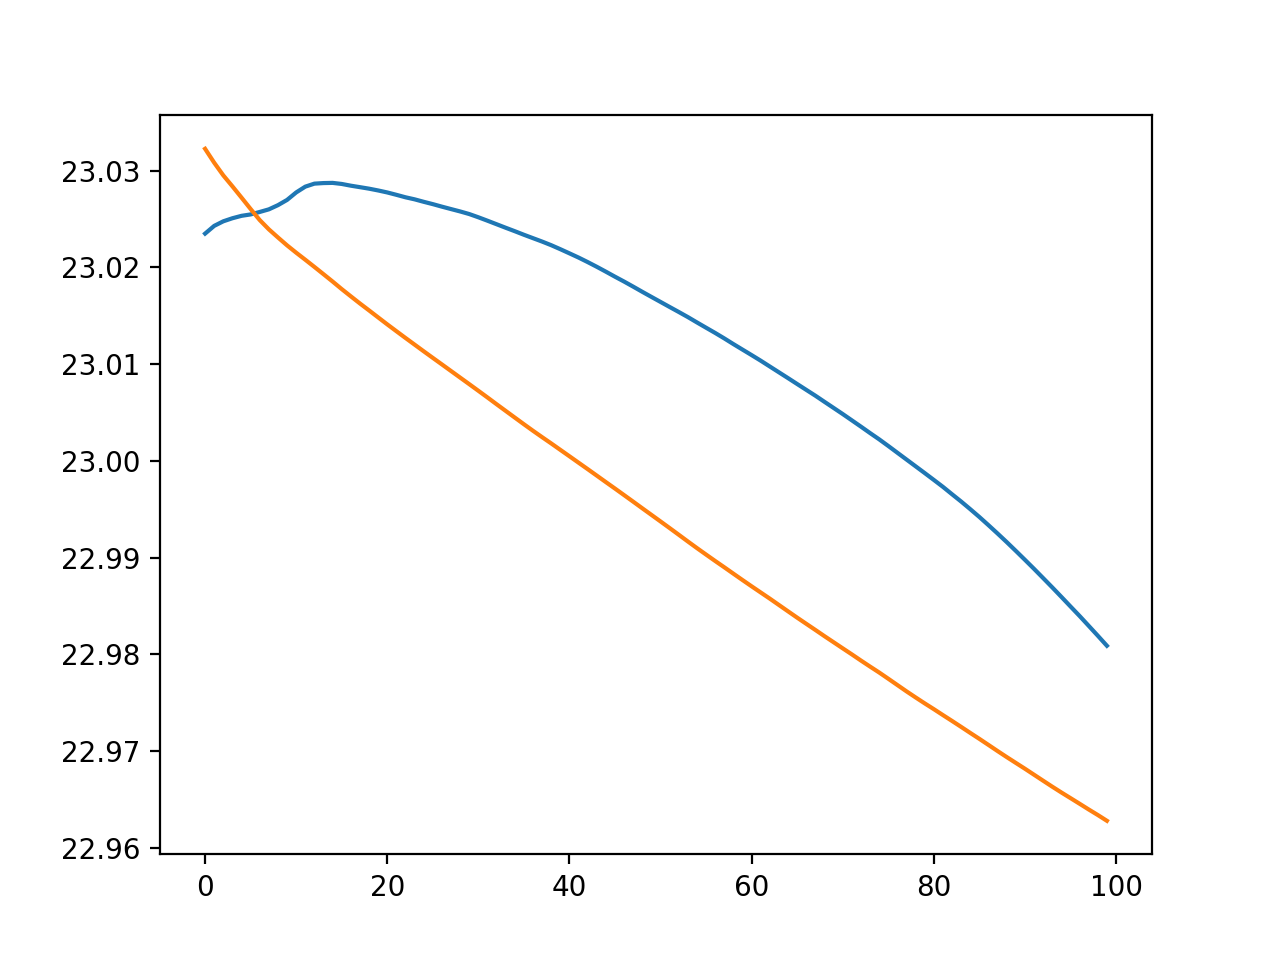

In [ ]:
losses = losses.view(100, 3)
fig = plt.figure()
plt.plot(torch.arange(100).detach().numpy(), losses[:,0].detach().numpy()) #loss1
fig = plt.figure()
plt.plot(torch.arange(100).detach().numpy(), losses[:,1].detach().numpy()) #loss2
plt.plot(torch.arange(100).detach().numpy(), losses[:,2].detach().numpy()) #loss3

In [ ]:
#Same as before but with 20x20 linear layer before the auxiliary loss
run_many_times(NetGroups3200Aux20_20,crit=nn.CrossEntropyLoss)

test error Net 19.30% 193/1000
test error Net 20.60% 206/1000
test error Net 21.10% 211/1000
test error Net 20.20% 202/1000
test error Net 20.50% 205/1000
test error Net 20.50% 205/1000
test error Net 20.70% 207/1000
test error Net 20.80% 208/1000
test error Net 21.40% 214/1000
test error Net 20.60% 206/1000
Average error: 20.57


In [ ]:
mini_batch_size=100
n=10
eta=1e-3
nb_epochs=100
crit=nn.CrossEntropyLoss
model = NetGroups3200Aux20_20()
losses = train_model(model, train_input, train_target,train_classes, mini_batch_size, crit, eta, nb_epochs,print_=False, store_loss = True)

<IPython.core.display.Javascript object>


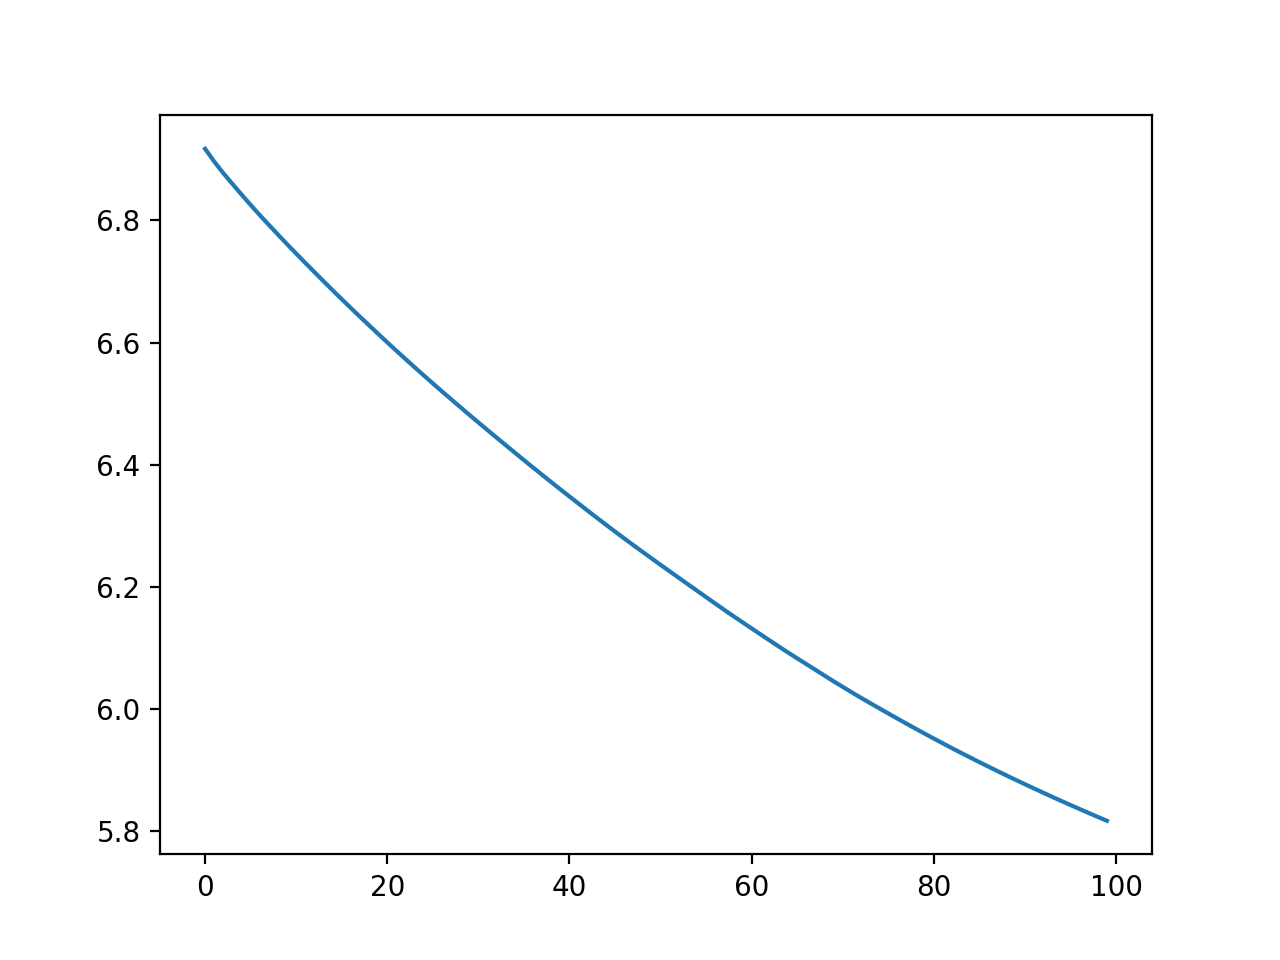

<IPython.core.display.Javascript object>


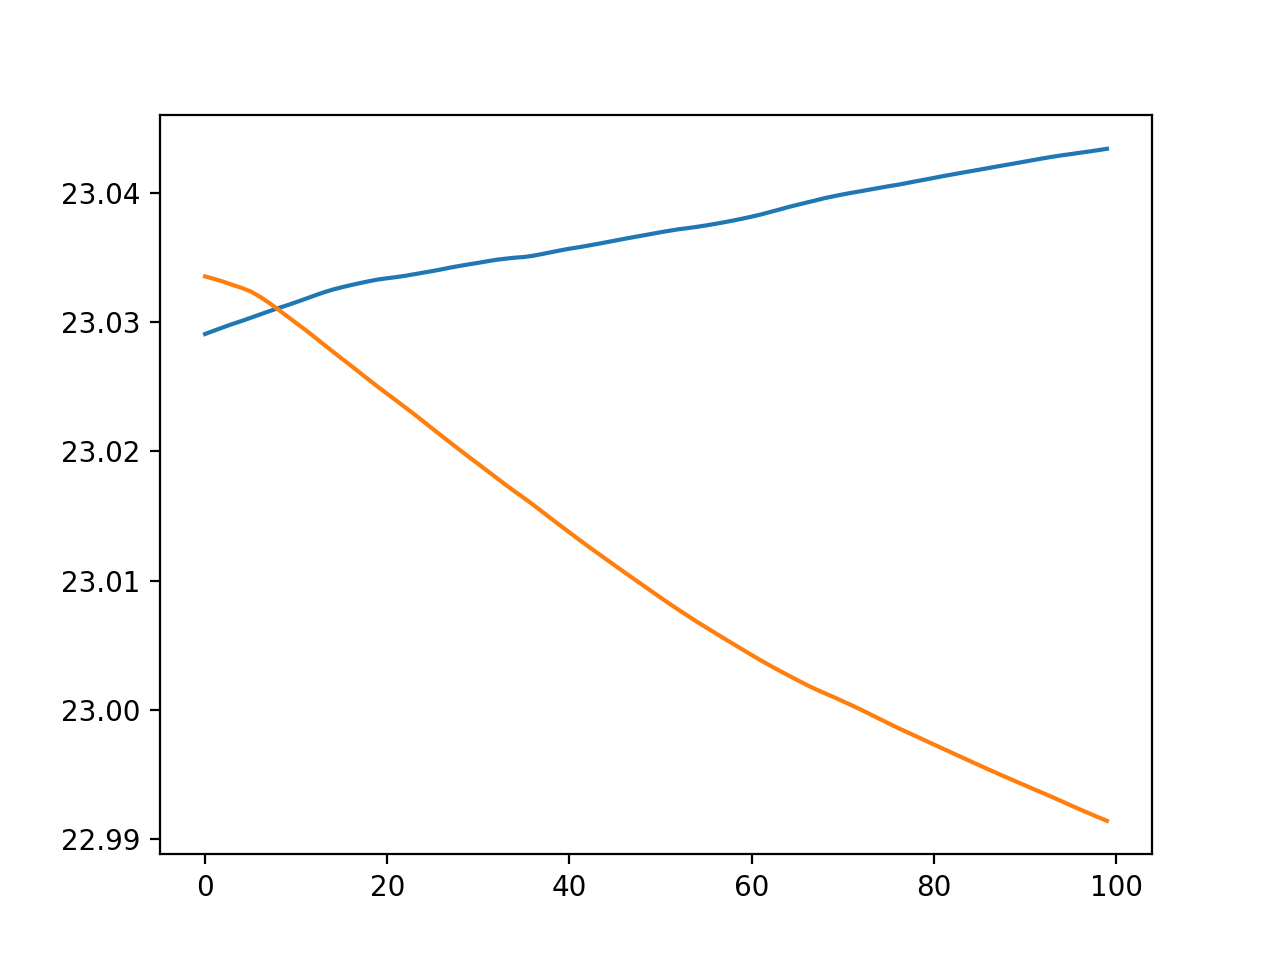

In [ ]:
losses = losses.view(100, 3)
fig = plt.figure()
plt.plot(torch.arange(100).detach().numpy(), losses[:,0].detach().numpy()) #loss1
fig = plt.figure()
plt.plot(torch.arange(100).detach().numpy(), losses[:,1].detach().numpy()) #loss2
plt.plot(torch.arange(100).detach().numpy(), losses[:,2].detach().numpy()) #loss3

In [ ]:
#Same as the first but with 2 linear layers
run_many_times(NetGroups1600_400Aux20,crit=nn.CrossEntropyLoss)

test error Net 22.50% 225/1000
test error Net 23.70% 237/1000
test error Net 22.60% 226/1000
test error Net 22.40% 224/1000
test error Net 23.00% 230/1000
test error Net 22.80% 228/1000
test error Net 22.70% 227/1000
test error Net 22.40% 224/1000
test error Net 24.20% 242/1000
test error Net 22.30% 223/1000
Average error: 22.860000000000003


In [ ]:
mini_batch_size=100
n=10
eta=1e-3
nb_epochs=100
crit=nn.CrossEntropyLoss
model = NetGroups1600_400Aux20()
losses = train_model(model, train_input, train_target,train_classes, mini_batch_size, crit, eta, nb_epochs,print_=False, store_loss = True)

<IPython.core.display.Javascript object>


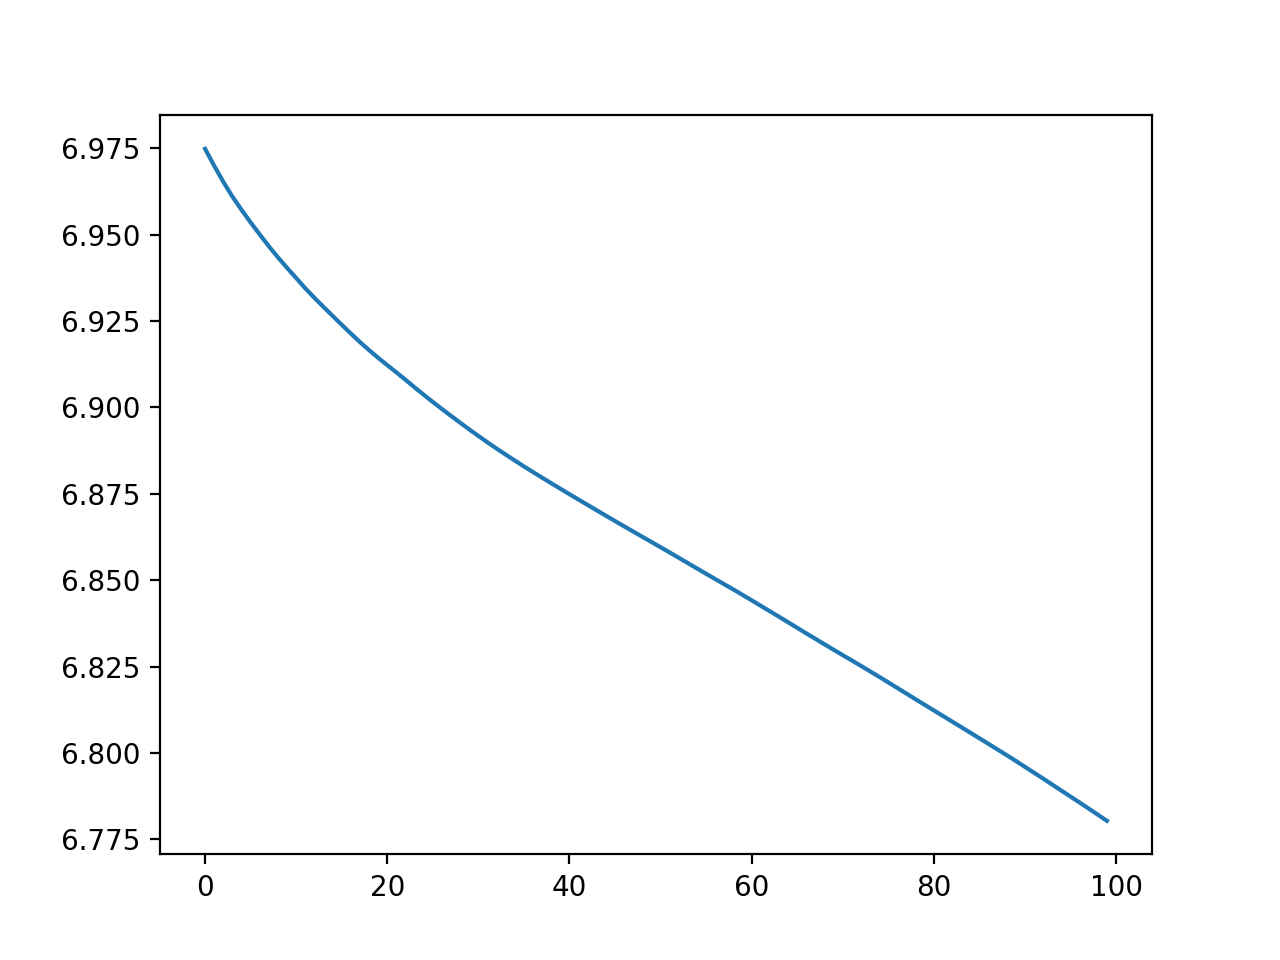

<IPython.core.display.Javascript object>


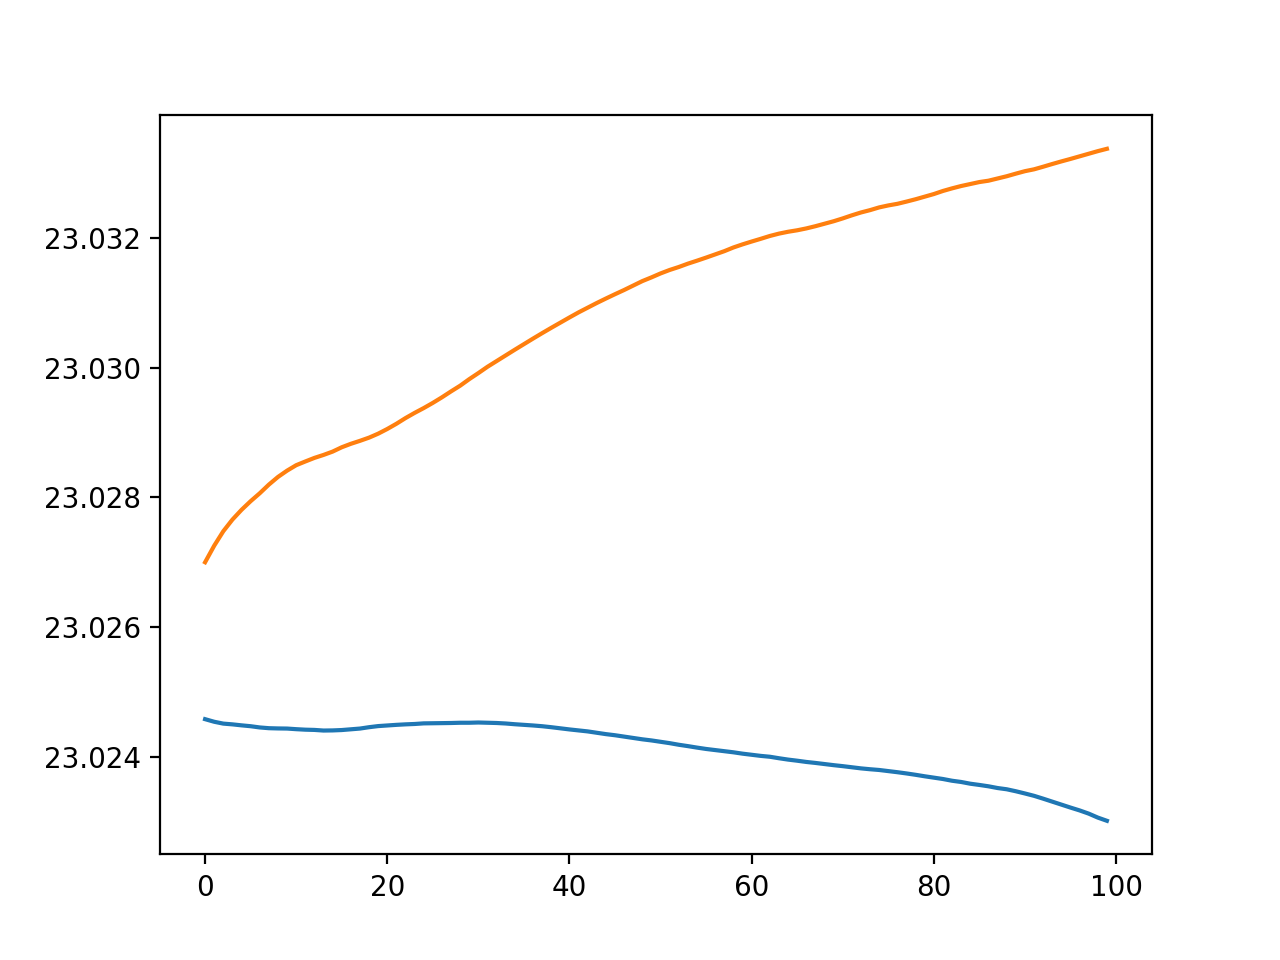

In [ ]:
losses = losses.view(100, 3)
fig = plt.figure()
plt.plot(torch.arange(100).detach().numpy(), losses[:,0].detach().numpy()) #loss1
fig = plt.figure()
plt.plot(torch.arange(100).detach().numpy(), losses[:,1].detach().numpy()) #loss2
plt.plot(torch.arange(100).detach().numpy(), losses[:,2].detach().numpy()) #loss3

In [ ]:
run_many_times(NetGroups320_160_80_40Aux20,crit=nn.CrossEntropyLoss)

test error Net 47.40% 474/1000
test error Net 47.40% 474/1000
test error Net 47.40% 474/1000
test error Net 47.40% 474/1000
test error Net 47.40% 474/1000
test error Net 47.40% 474/1000
test error Net 47.40% 474/1000
test error Net 47.40% 474/1000
test error Net 47.40% 474/1000
test error Net 47.40% 474/1000
Average error: 47.39999999999999


In [ ]:
mini_batch_size=100
n=10
eta=1e-3
nb_epochs=100
crit=nn.CrossEntropyLoss
model = NetGroups320_160_80_40Aux20()
losses = train_model(model, train_input, train_target,train_classes, mini_batch_size, crit, eta, nb_epochs,print_=False, store_loss = True)

<IPython.core.display.Javascript object>


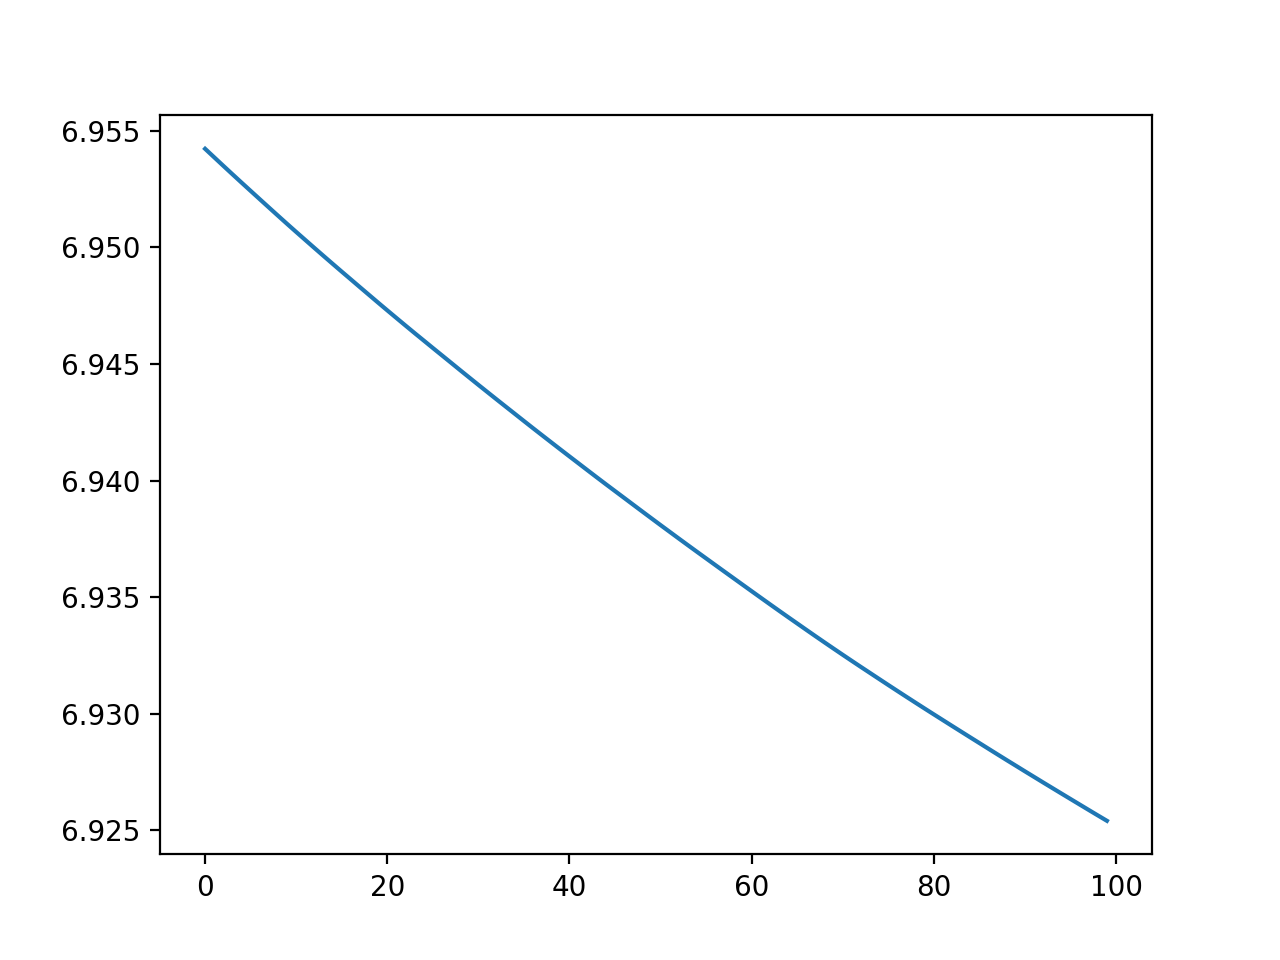

<IPython.core.display.Javascript object>


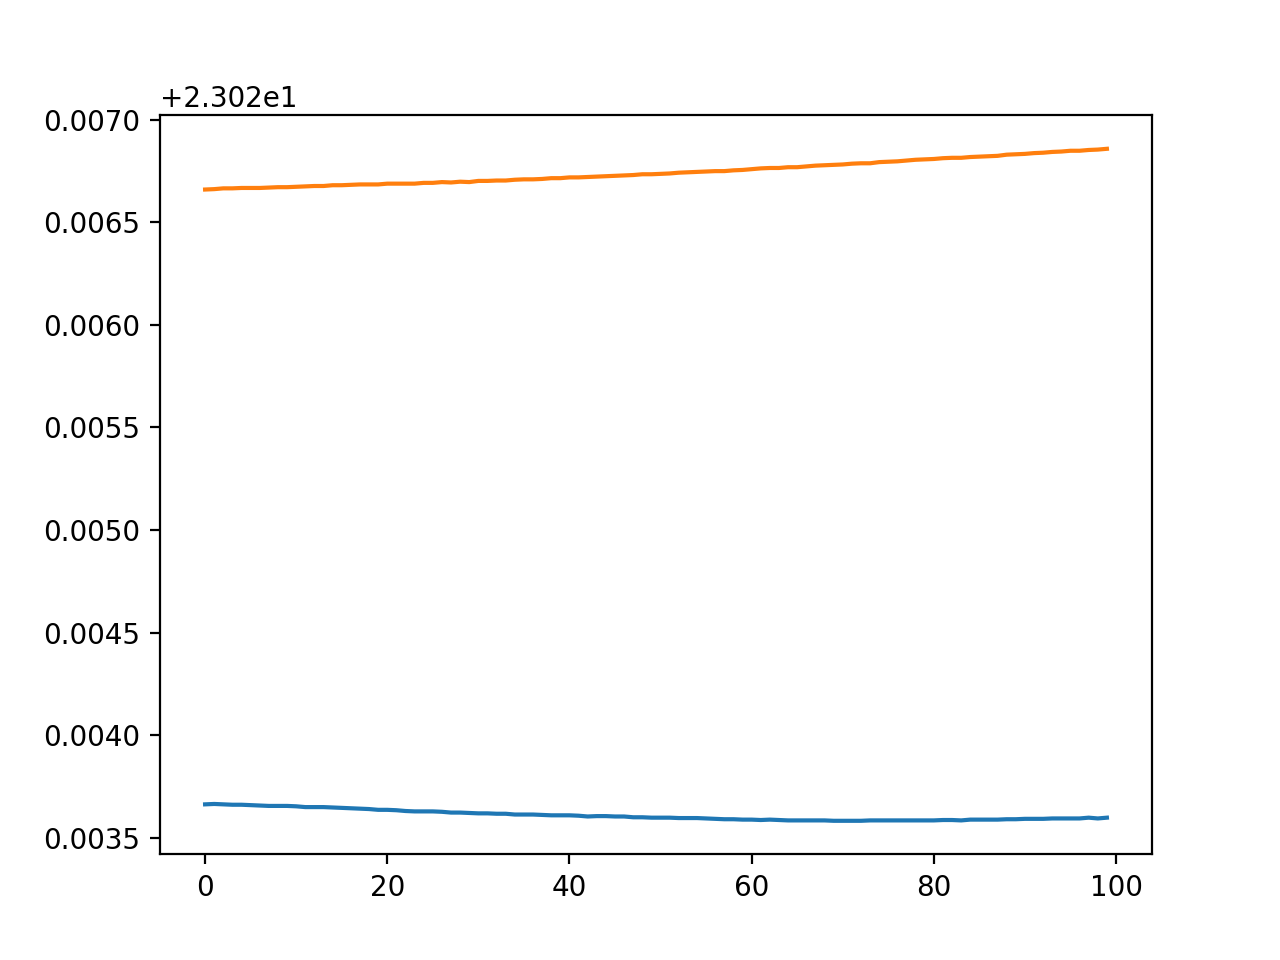

In [ ]:
losses = losses.view(100, 3)
fig = plt.figure()
plt.plot(torch.arange(100).detach().numpy(), losses[:,0].detach().numpy()) #loss1
fig = plt.figure()
plt.plot(torch.arange(100).detach().numpy(), losses[:,1].detach().numpy()) #loss2
plt.plot(torch.arange(100).detach().numpy(), losses[:,2].detach().numpy()) #loss3

In [ ]:
#This time with eta=1e-2 and 2000 epochs as the network is deeper
run_many_times(NetGroups320_160_80_40Aux20,crit=nn.CrossEntropyLoss,eta=1e-2,nb_epochs=2000)

test error Net 20.50% 205/1000
test error Net 19.00% 190/1000
test error Net 20.90% 209/1000
test error Net 20.00% 200/1000
test error Net 18.70% 187/1000
test error Net 20.30% 203/1000
test error Net 20.40% 204/1000
test error Net 19.20% 192/1000
test error Net 19.60% 196/1000
test error Net 21.80% 218/1000
Average error: 20.04


In [ ]:
mini_batch_size=100
n=10
eta=1e-3
nb_epochs=100
crit=nn.CrossEntropyLoss
model = NetGroups320_160_80_40Aux20()
losses = train_model(model, train_input, train_target,train_classes, mini_batch_size, crit, eta, nb_epochs,print_=False, store_loss = True)

<IPython.core.display.Javascript object>


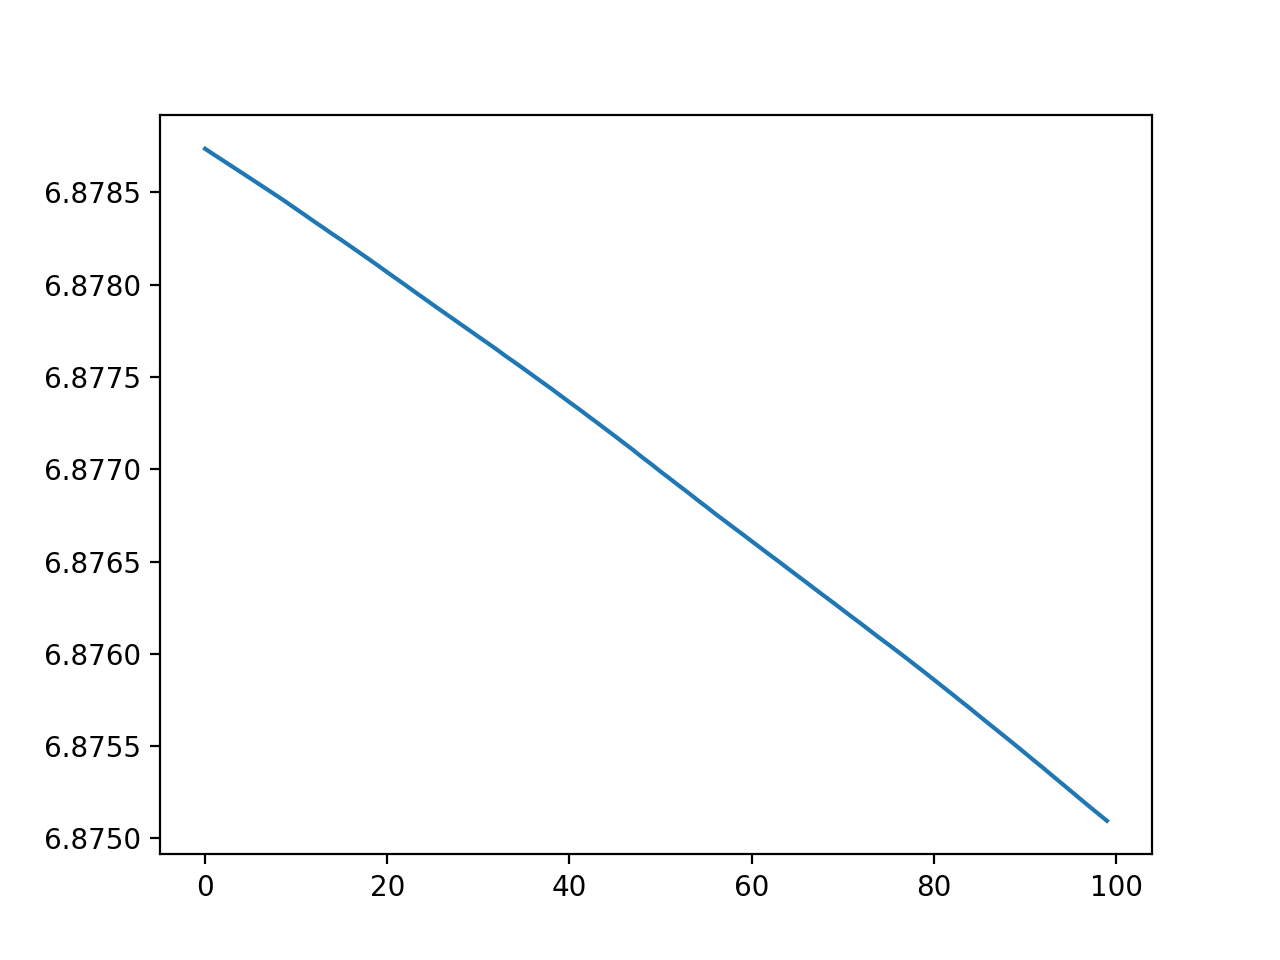

<IPython.core.display.Javascript object>


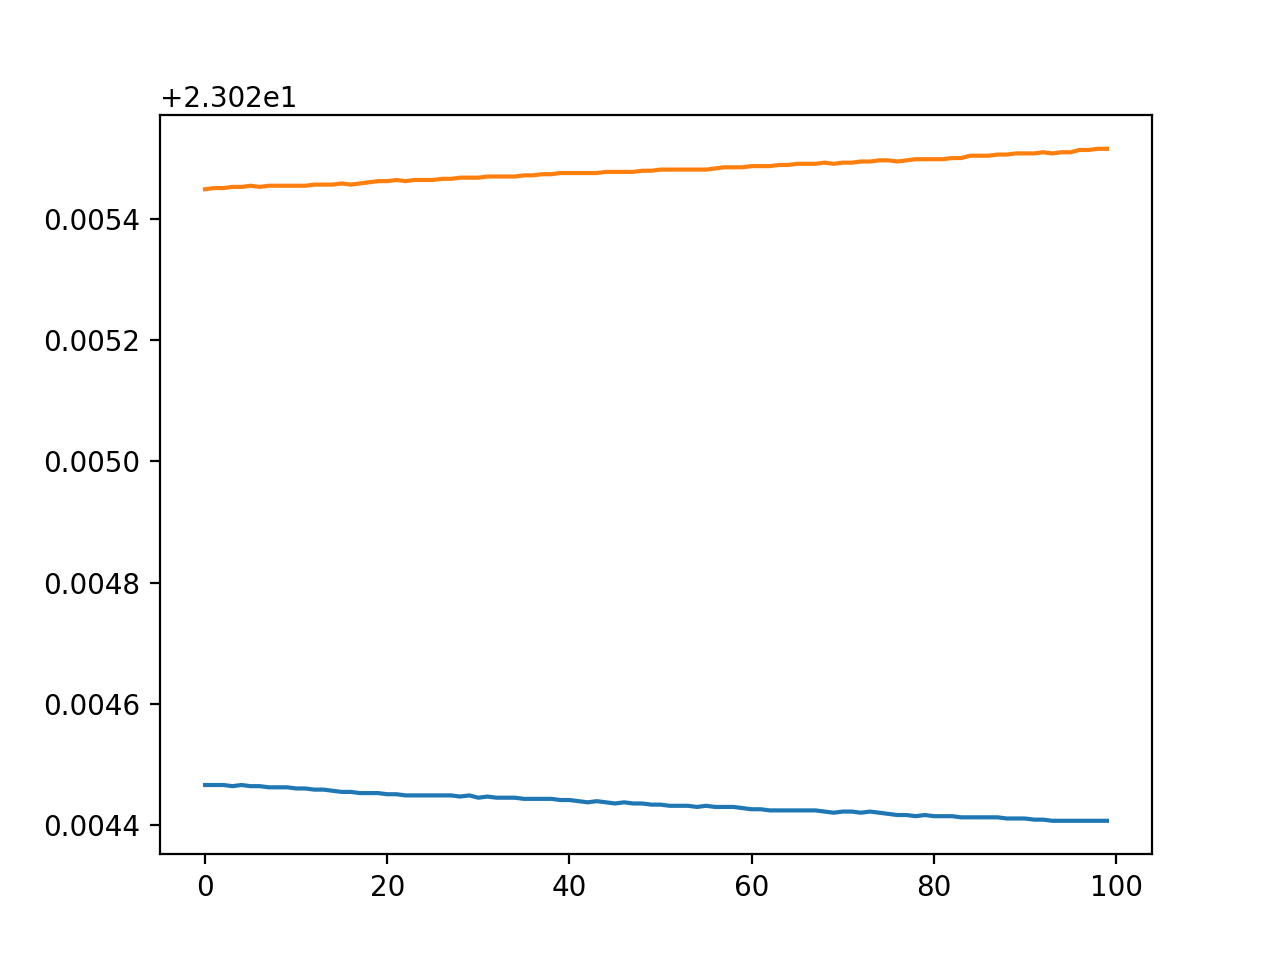

In [ ]:
losses = losses.view(100, 3)
fig = plt.figure()
plt.plot(torch.arange(100).detach().numpy(), losses[:,0].detach().numpy()) #loss1
fig = plt.figure()
plt.plot(torch.arange(100).detach().numpy(), losses[:,1].detach().numpy()) #loss2
plt.plot(torch.arange(100).detach().numpy(), losses[:,2].detach().numpy()) #loss3

In [ ]:
#Trying with 2 convolutional layers
run_many_times(NetGroupsDoubleConvAux20,crit=nn.CrossEntropyLoss)

test error Net 31.80% 318/1000
test error Net 46.80% 468/1000
test error Net 39.60% 396/1000
test error Net 45.40% 454/1000
test error Net 43.70% 437/1000
test error Net 33.80% 338/1000
test error Net 43.90% 439/1000
test error Net 41.50% 415/1000
test error Net 43.50% 435/1000
test error Net 36.40% 364/1000
Average error: 40.64


In [ ]:
mini_batch_size=100
n=10
eta=1e-3
nb_epochs=100
crit=nn.CrossEntropyLoss
model = NetGroupsDoubleConvAux20()
losses = train_model(model, train_input, train_target,train_classes, mini_batch_size, crit, eta, nb_epochs,print_=False, store_loss = True)

<IPython.core.display.Javascript object>


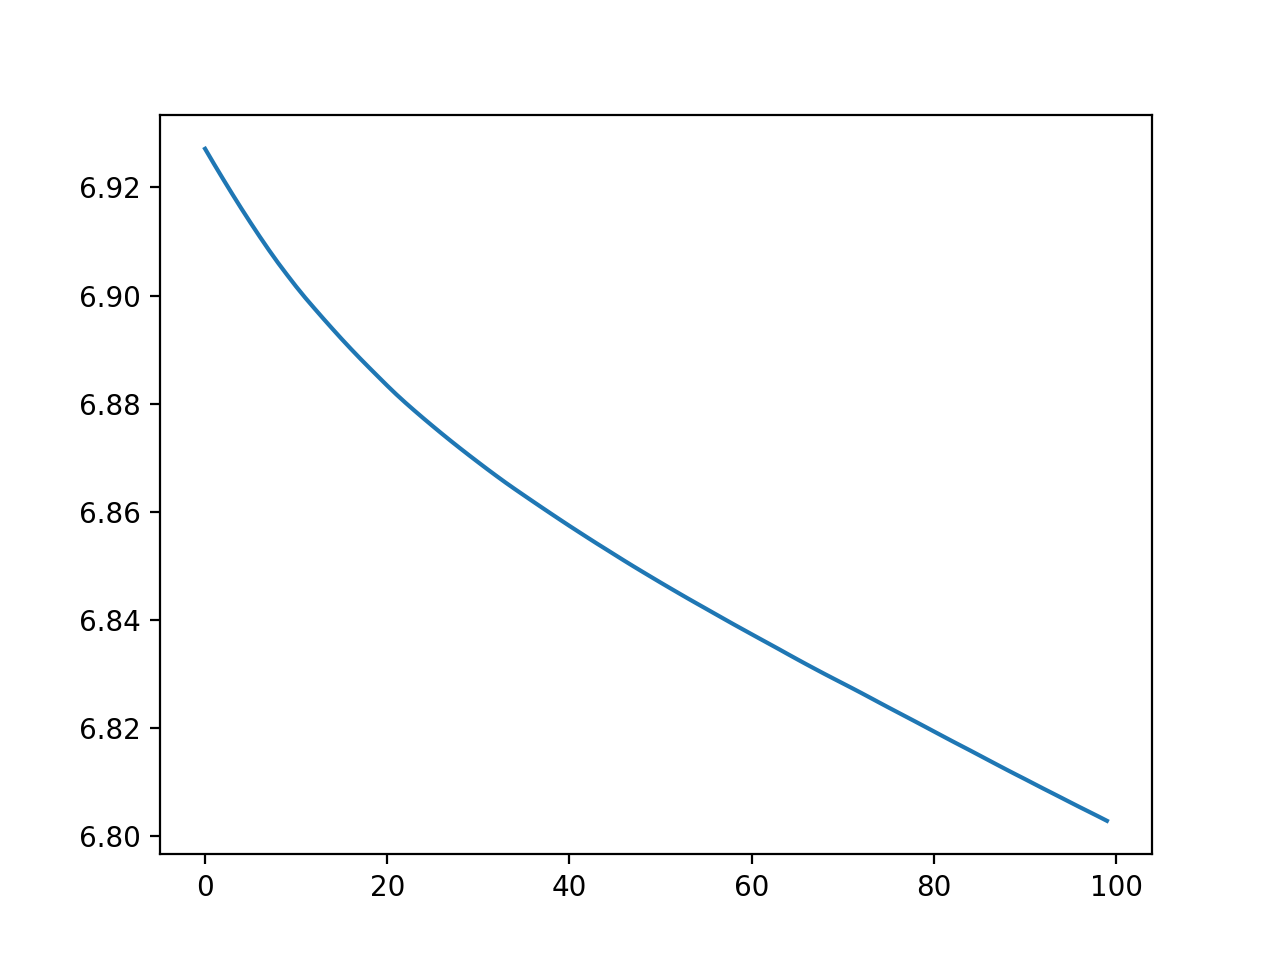

<IPython.core.display.Javascript object>


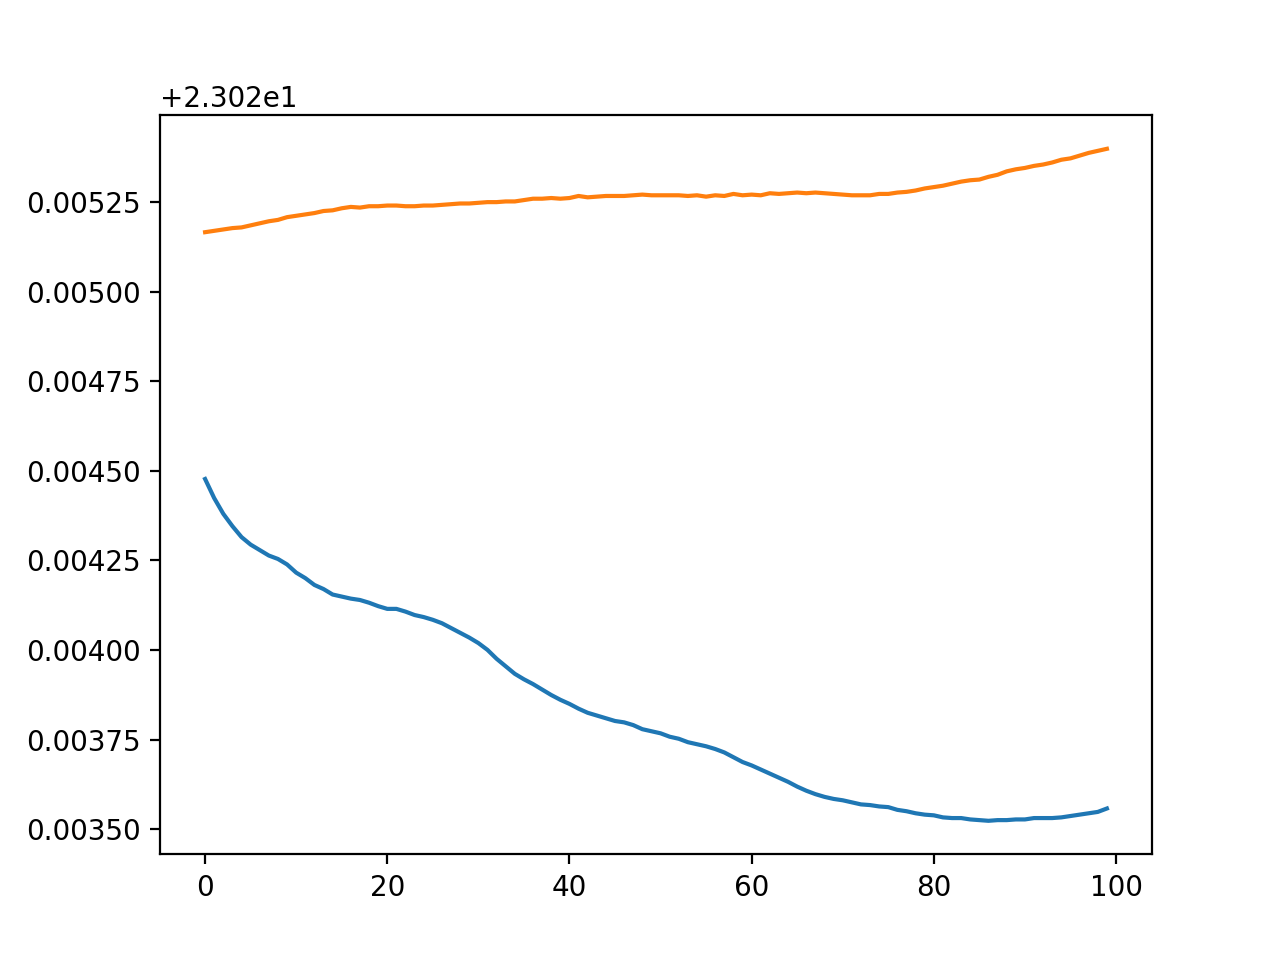

In [ ]:
losses = losses.view(100, 3)
fig = plt.figure()
plt.plot(torch.arange(100).detach().numpy(), losses[:,0].detach().numpy()) #loss1
fig = plt.figure()
plt.plot(torch.arange(100).detach().numpy(), losses[:,1].detach().numpy()) #loss2
plt.plot(torch.arange(100).detach().numpy(), losses[:,2].detach().numpy()) #loss3

In [ ]:
#This time with more epochs
run_many_times(NetGroupsDoubleConvAux20,crit=nn.CrossEntropyLoss,nb_epochs=2000)

test error Net 19.90% 199/1000
test error Net 21.60% 216/1000
test error Net 17.20% 172/1000
test error Net 18.60% 186/1000
test error Net 19.20% 192/1000
test error Net 20.60% 206/1000
test error Net 19.90% 199/1000
test error Net 18.80% 188/1000
test error Net 20.60% 206/1000
test error Net 19.70% 197/1000
Average error: 19.610000000000003


In [ ]:
mini_batch_size=100
n=10
eta=1e-3
nb_epochs=100
crit=nn.CrossEntropyLoss
model = NetGroupsDoubleConvAux20()
losses = train_model(model, train_input, train_target,train_classes, mini_batch_size, crit, eta, nb_epochs,print_=False, store_loss = True)

<IPython.core.display.Javascript object>


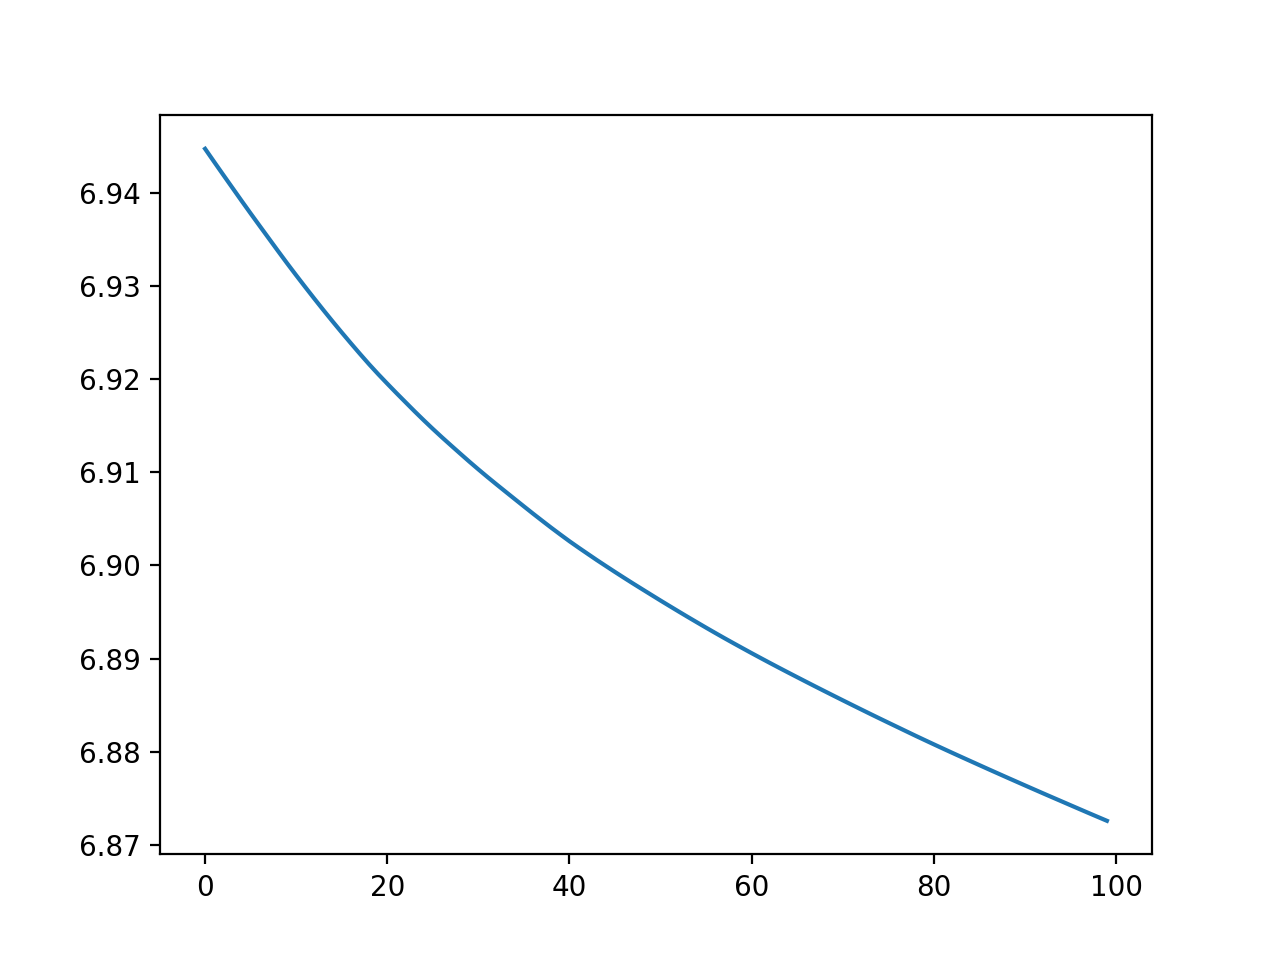

<IPython.core.display.Javascript object>


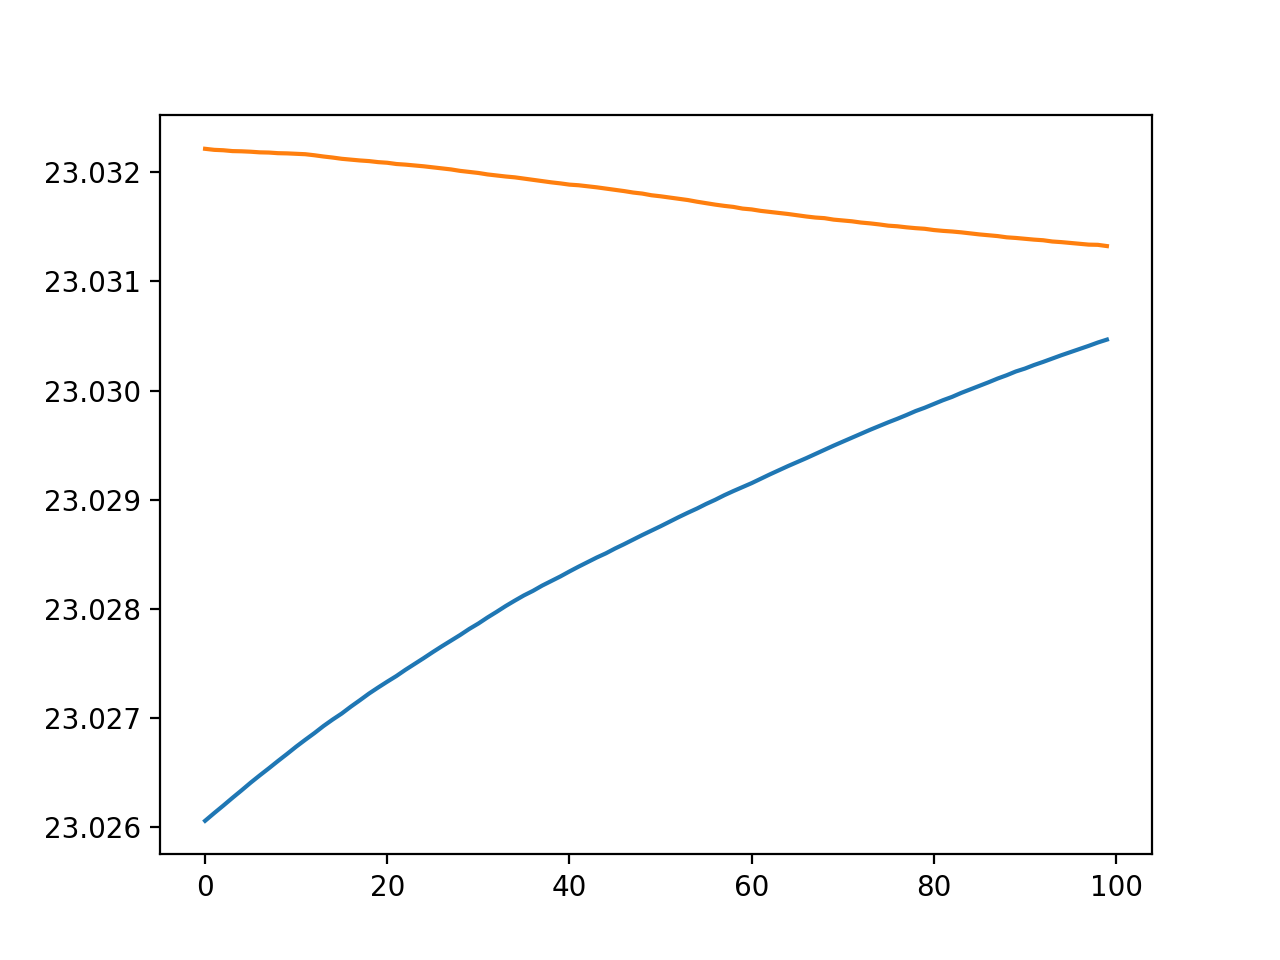

In [ ]:
losses = losses.view(100, 3)
fig = plt.figure()
plt.plot(torch.arange(100).detach().numpy(), losses[:,0].detach().numpy()) #loss1
fig = plt.figure()
plt.plot(torch.arange(100).detach().numpy(), losses[:,1].detach().numpy()) #loss2
plt.plot(torch.arange(100).detach().numpy(), losses[:,2].detach().numpy()) #loss3

In [ ]:
run_many_times(NetGroups320_80DoubleConvAux20,crit=nn.CrossEntropyLoss,nb_epochs=2000)

test error Net 47.40% 474/1000
test error Net 47.40% 474/1000
test error Net 47.40% 474/1000
test error Net 47.40% 474/1000
test error Net 22.50% 225/1000
test error Net 47.40% 474/1000
test error Net 47.40% 474/1000
test error Net 47.40% 474/1000
test error Net 47.40% 474/1000
test error Net 47.40% 474/1000
Average error: 44.90999999999999


In [ ]:
mini_batch_size=100
n=10
eta=1e-3
nb_epochs=100
crit=nn.CrossEntropyLoss
model = NetGroups320_80DoubleConvAux20()
losses = train_model(model, train_input, train_target,train_classes, mini_batch_size, crit, eta, nb_epochs,print_=False, store_loss = True)

<IPython.core.display.Javascript object>


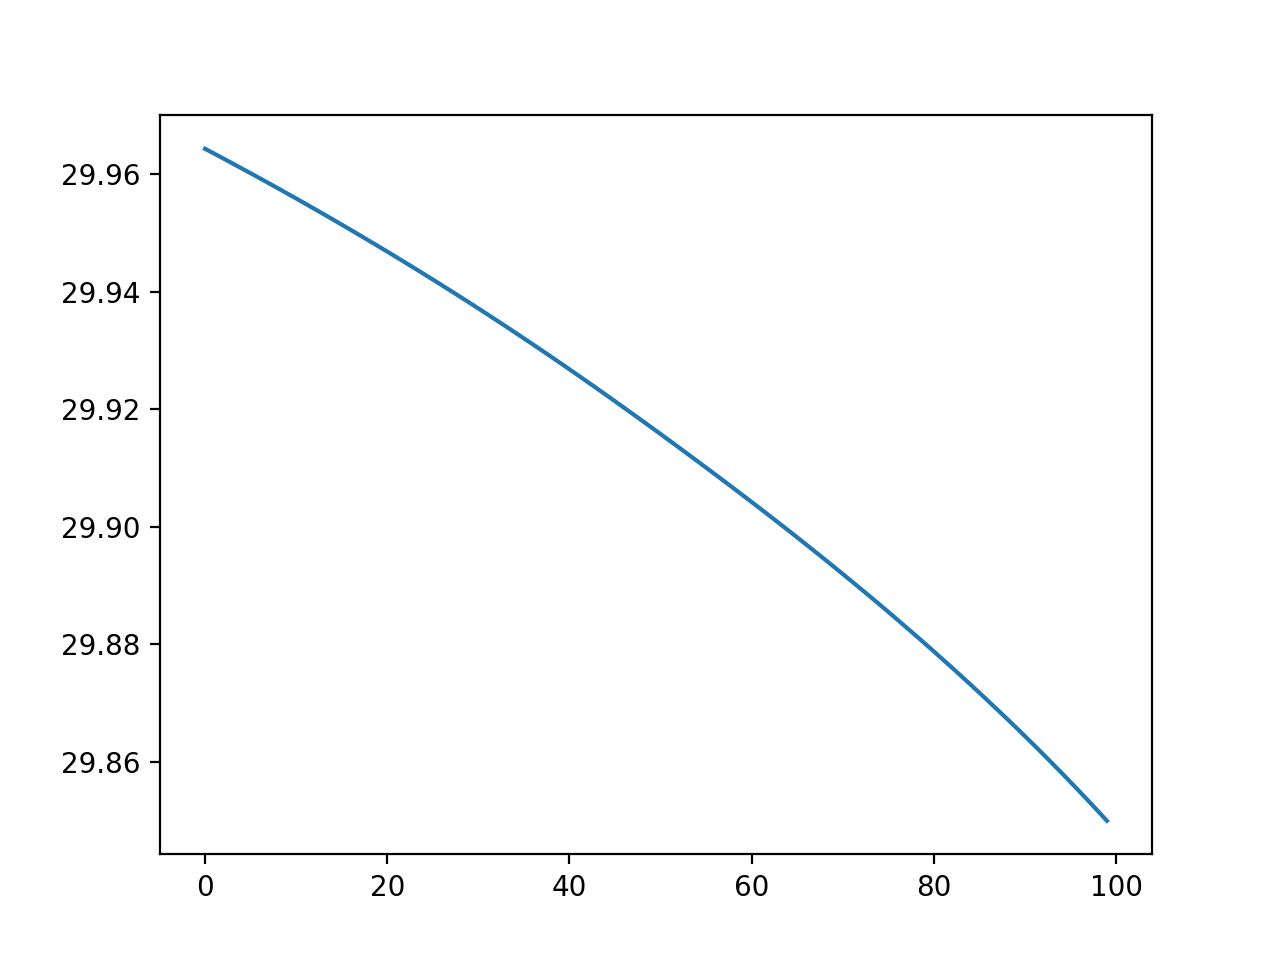

<IPython.core.display.Javascript object>


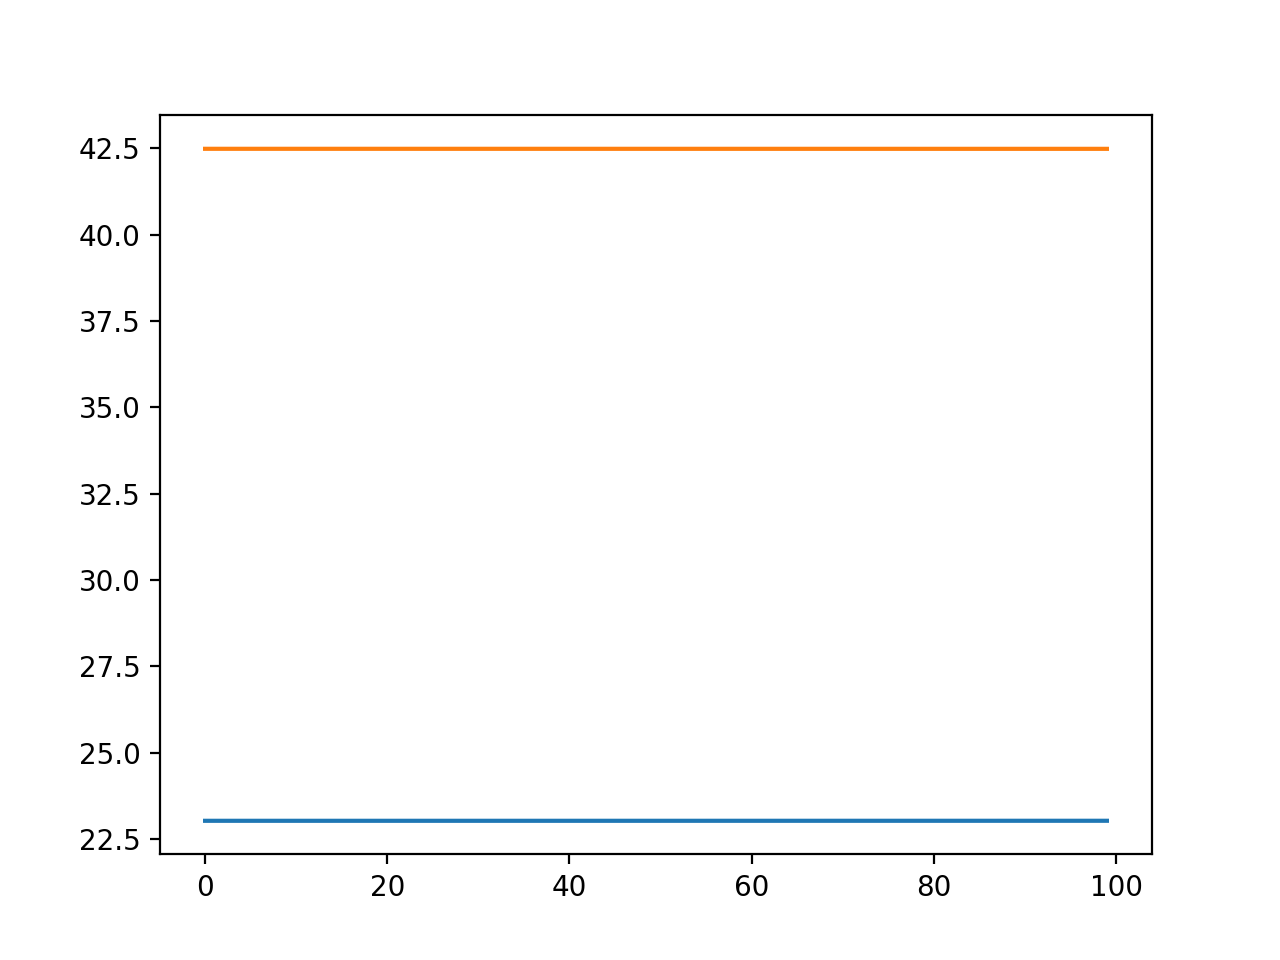

In [ ]:
losses = losses.view(100, 3)
fig = plt.figure()
plt.plot(torch.arange(100).detach().numpy(), losses[:,0].detach().numpy()) #loss1
fig = plt.figure()
plt.plot(torch.arange(100).detach().numpy(), losses[:,1].detach().numpy()) #loss2
plt.plot(torch.arange(100).detach().numpy(), losses[:,2].detach().numpy()) #loss3

In [ ]:
#Try with a different eta
run_many_times(NetGroups320_80DoubleConvAux20,crit=nn.CrossEntropyLoss,eta=1e-2,nb_epochs=2000)

test error Net 47.40% 474/1000
test error Net 47.40% 474/1000
test error Net 47.40% 474/1000
test error Net 47.40% 474/1000
test error Net 47.40% 474/1000
test error Net 18.00% 180/1000
test error Net 47.40% 474/1000
test error Net 47.40% 474/1000
test error Net 17.80% 178/1000
test error Net 47.40% 474/1000
Average error: 41.49999999999999


In [ ]:
#Again with smaller eta this time
run_many_times(NetGroups320_80DoubleConvAux20,crit=nn.CrossEntropyLoss,eta=1e-4,nb_epochs=2000)

test error Net 52.60% 526/1000
test error Net 52.60% 526/1000
test error Net 47.40% 474/1000
test error Net 52.60% 526/1000


In [ ]:
run_many_times(NetGroups320_80DoubleConvAux20,crit=nn.CrossEntropyLoss,eta=1e-1,nb_epochs=2000)